In [5]:
import numpy as np
import os
from numpy import roots
from numpy.polynomial import Polynomial as P
import matplotlib.pyplot as plt


In [6]:
# X-Median (px), Y-Median (px), X-Peak (px), Y-Peak (px), X-Location (mm), Y-Location (mm)
data={}
for i in range(55,145):
    if i<100:
        data[i]= (np.loadtxt(f"BeamLoc_D1542_D1542_9_12_dipole_scan_0{i}.csv")[4],np.loadtxt(f"BeamLoc_D1542_D1542_9_12_dipole_scan_0{i}.csv")[5])
    else:
        data[i]= (np.loadtxt(f"BeamLoc_D1542_D1542_9_12_dipole_scan_{i}.csv")[4],np.loadtxt(f"BeamLoc_D1542_D1542_9_12_dipole_scan_{i}.csv")[5])


In [7]:
#data

## - error is estimated as +/-1.5 pixels max per data point, according to the FP2 analysis I did for the DOE report. The optimizer branch of the viewer analysis which i used for this does NOT yet include error propagation (need to add soon!)

## - This data is at FP1 which as of now has much cleaner data, meaning this error might be an overestimation. I need to add the errors to the analysis to check.

## - scale is 0.1 mm for 1 pixel, therefore the error is +/- 0.15 mm per point.


In [8]:
def Dist(x, y):
    meas_num=  len(x)*2
    dist= 1/meas_num * (np.power((x[0]-x[1]),2)
                      + np.power((y[0]-y[1]),2)
                      + np.power((x[1]-x[2]),2) 
                      + np.power((y[1]-y[2]),2) 
                      + np.power((x[0]-x[2]),2) 
                      + np.power((y[0]-y[2]),2)
                       ) 
    return dist

## error propagation

d here is before taking the square root

$ \delta d = \sqrt{ \delta_{meas}^{2} . ((\frac{ \delta d}{\delta x_{0}})^{2} +  (\frac{\delta d}{\delta x_{1}})^{2} + (\frac{\delta d}{\delta x_{2}})^{2} + (\frac{\delta d}{\delta y_{0}})^{2} + (\frac{ \delta d}{\delta y_{1}})^{2} + (\frac{\delta d}{\delta y_{2}})^{2}       ) }$


In [9]:
def Err(d, x, y): # d here is not sqrt(d)
    err_factor = 0.28  #in mm, 2 pixels of error 
    meas_num =  len(x)*2
    
    delta_d = 2* err_factor/meas_num * np.sqrt( (2*x[0]-x[1]-x[2])**(2) + (x[0]+x[2])**(2) + (2*x[2]-x[0]-x[1])**(2) + (2*y[0]-y[1]-y[2])**2 + (y[2]+y[0])**2 + (2*y[2]-y[1]-y[0])**2  )    
    
    #applying error propagation for square root of d
    delta_sqrtd = (delta_d)/(2*np.sqrt(d))  
    
    #return error on sqrt(d)
    return delta_sqrtd

In [10]:
distances= []
errors = []

for i in range(55, 143, 3):
    
    x_dist=[]
    y_dist=[]
    
    for j in range(i, i+3):
        x_dist.append(data[j][0])
        y_dist.append(data[j][1])
    
    dist_ = Dist(x_dist, y_dist)  
    
    distances.append(np.sqrt(dist_))
    #not passing the sqrt version of the distance here, but returning the error on sqrt(d)
    errors.append(Err(dist_, x_dist, y_dist))
    

In [11]:
#avg of fields recorded at each measurement
avg_fields= [0.231274,0.2312545,0.231229,0.2311695,0.231151,0.2311,0.231065,0.2310305,0.2309955,0.230969,0.230927,0.230891,0.2308555,0.2308215,0.230785,0.2307515,0.2307155,0.230681,0.2306455,0.2306265,0.230576,0.230548,0.230506,0.230486,0.230436,0.230394,0.230367,0.2303245,0.2302885,0.2302545]

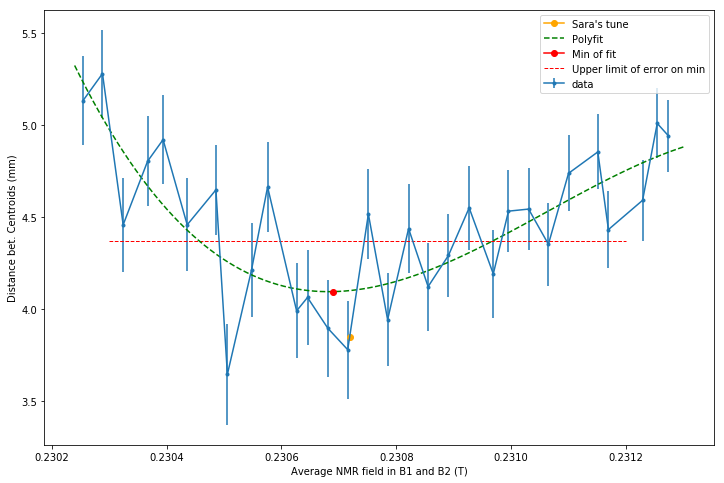

In [12]:
%matplotlib inline
fig= plt.figure(figsize=(12,8))
plt.errorbar(avg_fields, distances, yerr= errors,  marker='.', label= 'data')
plt.plot( 0.230719, 3.85, marker='.', color='orange', markersize=12, label = 'Sara\'s tune')

plt.xlabel('Average NMR field in B1 and B2 (T)')
plt.ylabel('Distance bet. Centroids (mm)')
#plt.xticks(np.arange(0.23024, 0.2313, 0.0001))

z = np.polyfit(avg_fields, distances, 3, w= errors)
p = np.poly1d(z)

xp= np.linspace(0.23024, 0.2313, 100)
plt.plot(xp, p(xp), '--' , color='green', label='Polyfit')
plt.plot(0.23069, p(xp).min(), marker='.', color='red', markersize= 12, label = 'Min of fit')
plt.hlines(p(xp).min()+max(errors),0.2303, 0.2312, color='red', linewidth=1, linestyles='dashed', label ='Upper limit of error on min')

#plt.ylim(4.0,4.4)
#plt.xlim(0.2304, 0.231)
plt.legend()
plt.show()
#plt.savefig("dipolescan_dist_field.png", dpi=300)

In [13]:
#diff between min and my tune
diff = (0.23069-0.230719)/0.23069*100
abs(diff)

0.012570982704062266

In [14]:
#need this to get where red line (upper lim) intersects this fit
p = P.fit(avg_fields, distances, 3)

In [15]:
#getting the roots
roots_ = (p - (p(xp).min()+max(errors))).roots()
dB_total = roots_[1]-roots_[0]

print('roots: ',roots_ ,' dB total: ', dB_total)

roots:  [0.23045864 0.23097994 0.23183413]  dB total:  0.0005213049927614288


-211184679318.87366

In [20]:
#+/- error in percent of B min 
dB_total/(2*0.23069)*100

0.11298820771629217

#  - the error on my 'minimum' field is then 0.0005 T total

# - this is +/- 0.113% of the minimum field from this curve

# - taking this as the error on our field from tuning


### ---------- extreme case of 1 mm error --------------

In [21]:
#If i take the error as 1 mm (extreme case) then the red line is high enough that it would be the 
# difference from the leftmost root 0.23027797 and the last data point on the right
(0.23027797- 0.2313)/(2*0.23069)*100

-0.2215158871212465

### this extreme case would be +/-0.2215% error, twice as big as when I took the error to be 2 pixels